<a href="https://colab.research.google.com/github/the-pinbo/image-compression/blob/main/01_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim

In [2]:
#Download the dataset
mnist = tf.keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
print(f"X_train.shape => {X_train.shape}")
print(f"X_test.shape => {X_test.shape}")
print(f"Y_train.shape => {Y_train.shape}")
print(f"Y_test.shape => {Y_test.shape}")

11490434/11490434 [==============================] - 0s 0us/step
X_train.shape => (60000, 28, 28)
X_test.shape => (10000, 28, 28)
Y_train.shape => (60000,)
Y_test.shape => (10000,)


In [3]:
# Sorting the dataset into 0, 1, 2, ..., 9 in X_train based on Y_train
sorted_indices = Y_train.argsort()
sorted_X_train = X_train[sorted_indices]
sorted_Y_train = Y_train[sorted_indices]

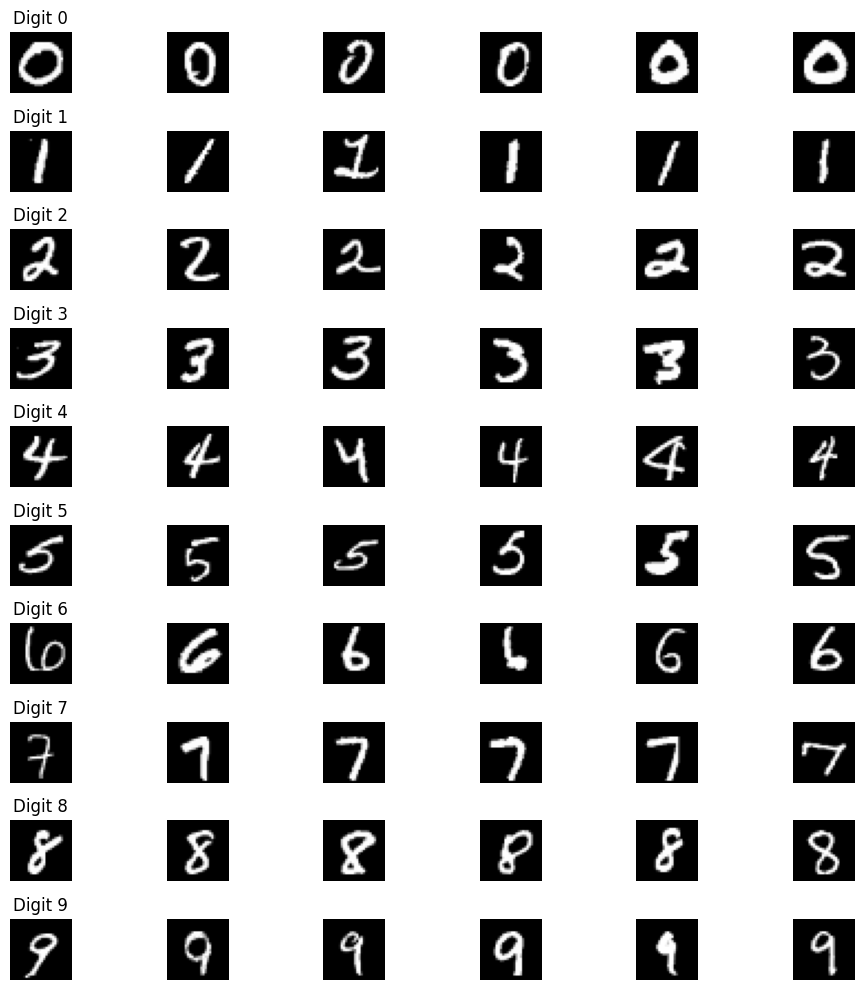

In [4]:
# Function to plot 6 images of each digit in a rectangular grid
def plot_images(X, Y, num_classes=10, samples_per_class=6):
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(10, 10))
    axes = axes.ravel()

    for i in range(num_classes):
        # Find indices of the first 6 images of class i
        indices = np.where(Y == i)[0][:samples_per_class]
        for j, idx in enumerate(indices):
            ax = axes[i * samples_per_class + j]
            ax.imshow(X[idx], cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.set_title(f"Digit {i}")

    plt.tight_layout()
    plt.show()

# Example usage with the sorted MNIST dataset
plot_images(sorted_X_train, sorted_Y_train)  # Uncomment this line to run in your environment


In [5]:
# Reshape the training data to 2D (n_samples, n_features)
m, n = sorted_X_train.shape[1], sorted_X_train.shape[2]  # Image dimensions
X_train_flat = sorted_X_train.reshape((-1, m * n)).T
print(f"X_train_flat.shape => {X_train_flat.shape}")

# Compute the average digit
avg_digit = np.mean(X_train_flat, axis=1)

# Perform mean subtraction
X_centered = X_train_flat - avg_digit[:,np.newaxis]
print(f"X_centered.shape => {X_centered.shape}")

X_train_flat.shape => (784, 60000)
X_centered.shape => (784, 60000)


In [6]:
# Compute SVD
U, S, VT = np.linalg.svd(X_centered, full_matrices=False)
print(f"U.shape => {U.shape}")
print(f"S.shape => {S.shape}")
print(f"VT.shape => {VT.shape}")

U.shape => (784, 784)
S.shape => (784,)
VT.shape => (784, 60000)


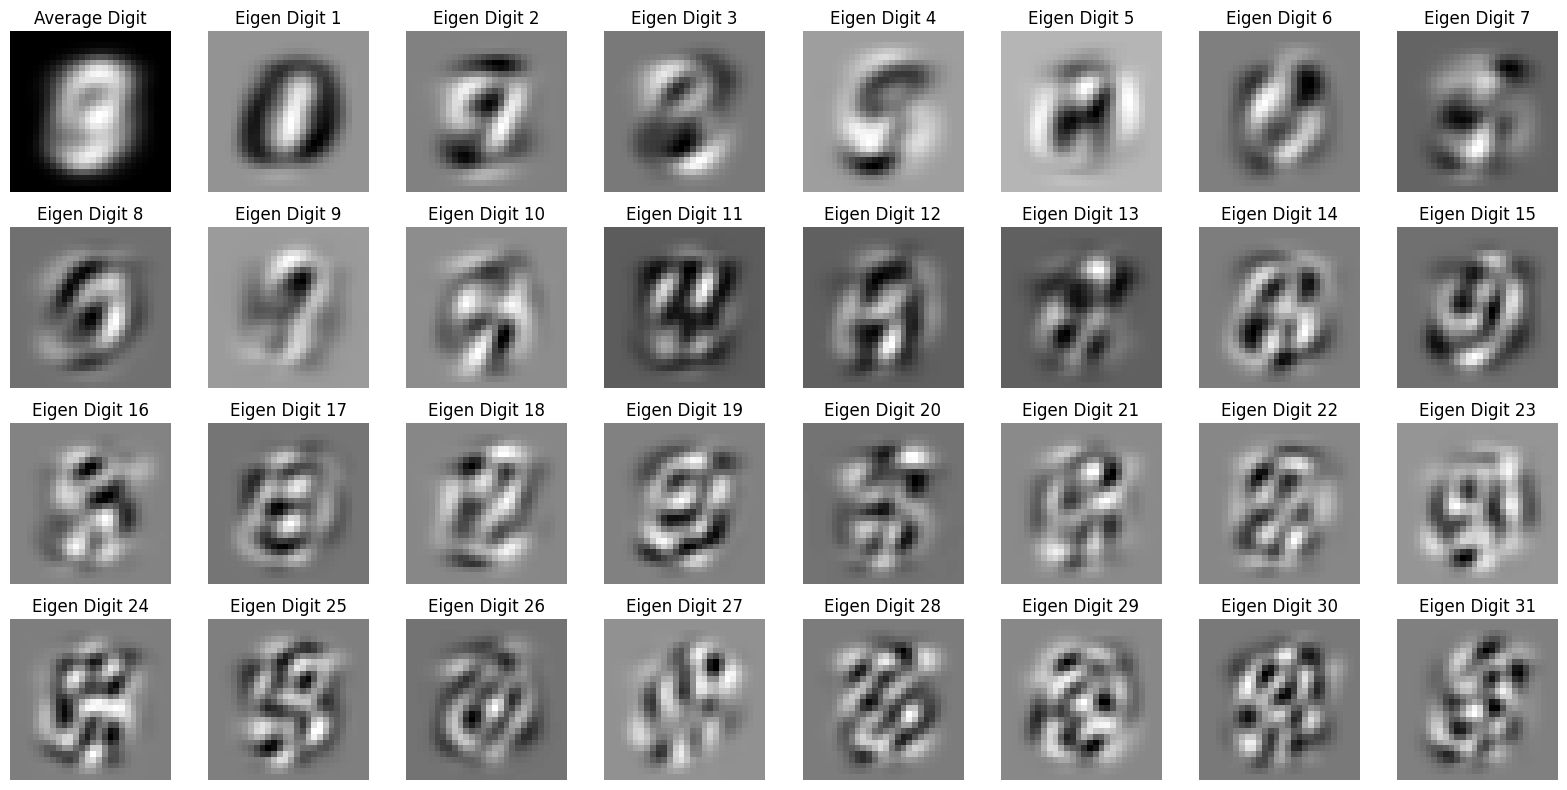

In [7]:
# Set up the matplotlib figure and axes, based on the number of eigen digits
fig, axes = plt.subplots(4, 8, figsize=(16, 8))  # 4x7 grid for 28 images
axes = axes.ravel()

# Average digit
img_avg = axes[0].imshow(avg_digit.reshape(m, n), cmap='gray')
axes[0].set_title('Average Digit')
axes[0].axis('off')

for i in range(31):
    # Plot each eigen digit
    ax = axes[i+1]
    eigen_digit = U[:, i].reshape(m, n)
    ax.imshow(eigen_digit, cmap='gray')
    ax.set_title(f'Eigen Digit {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

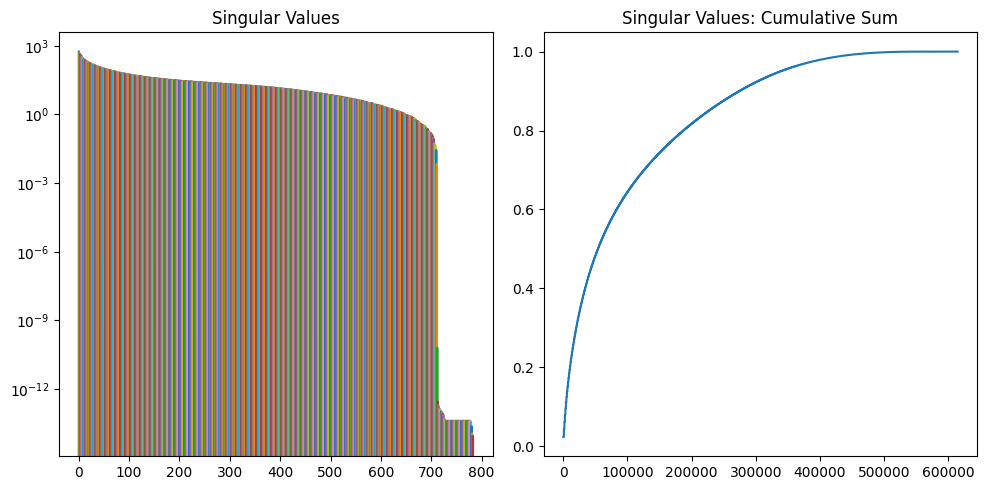

In [8]:
# Plotting both figures side by side with reduced size

plt.figure(figsize=(10, 5))  # Set the figure size to be more compact

# Plot of singular values on a semilog scale
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.semilogy(np.diag(S))
plt.title('Singular Values')

# Plot of the cumulative sum of singular values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(np.cumsum(np.diag(S)) / np.sum(np.diag(S)))
plt.title('Singular Values: Cumulative Sum')

plt.tight_layout()  # Adjust subplots to fit in to the figure area.
plt.show()

In [9]:
X_test_flat = X_test.reshape((-1, m * n))
print(f"X_test_flat.shape => {X_test_flat.shape}")

X_test_flat.shape => (10000, 784)


In [10]:
# Define a function to calculate PSNR between the original and compressed images
def calculate_psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Define a function to calculate SSIM between the original and compressed images
def calculate_ssim(original, compressed):
    return ssim(original, compressed, data_range=compressed.max() - compressed.min())

def plot_analysis(test_digit):
    # Mean subtraction from the test digit
    test_digit_MS = test_digit - avg_digit

    # Define the list of ranks to be used for reconstruction
    r_list = [10, 50, 100, 200, 300, 400, 500]

    # Initialize lists to store PSNR and SSIM values
    psnr_values = []
    ssim_values = []

    # Calculate the compressed digits and their PSNR and SSIM values
    compressed_digits = []
    for r in r_list:
        # Compress the digit using the first 'r' eigen digits
        compressed_digit = avg_digit + U[:, :r] @ U[:, :r].T @ test_digit_MS
        compressed_digits.append(compressed_digit)

        # Calculate PSNR and SSIM
        psnr_values.append(calculate_psnr(test_digit, compressed_digit))
        ssim_values.append(calculate_ssim(test_digit, compressed_digit))

    # Plot the original and compressed digits with their corresponding PSNR and SSIM values
    fig, axes = plt.subplots(2, len(r_list)+1, figsize=(14, 3))  # +1 for the original image

    # Plot the original digit
    axes[0, 0].imshow(test_digit.reshape(m, n), cmap='gray')
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')

    # Plot the PSNR and SSIM values below the original image
    axes[1, 0].text(0.5, 0.5, 'Original', horizontalalignment='center', verticalalignment='center')
    axes[1, 0].axis('off')

    for i, r in enumerate(r_list):
        # Show the compressed digit
        axes[0, i+1].imshow(compressed_digits[i].reshape(m, n), cmap='gray')
        axes[0, i+1].set_title(f'r={r}')
        axes[0, i+1].axis('off')

        # Show the PSNR and SSIM values
        axes[1, i+1].text(0.5, 0.6, f'PSNR: {psnr_values[i]:.2f} dB', ha='center')
        axes[1, i+1].text(0.5, 0.4, f'SSIM: {ssim_values[i]:.4f}', ha='center')
        axes[1, i+1].axis('off')

    plt.tight_layout()
    plt.show()

    # Plot the PSNR and SSIM graphs
    fig, ax1 = plt.subplots(figsize=(8, 4))

    color = 'tab:red'
    ax1.set_xlabel('Number of Eigen Digits')
    ax1.set_ylabel('PSNR (dB)', color=color)
    ax1.plot(r_list, psnr_values, 'o-', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('SSIM', color=color)  # we already handled the x-label with ax1
    ax2.plot(r_list, ssim_values, 's-', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.grid(True)
    plt.title('PSNR and SSIM Values for Different Numbers of Eigen Digits')

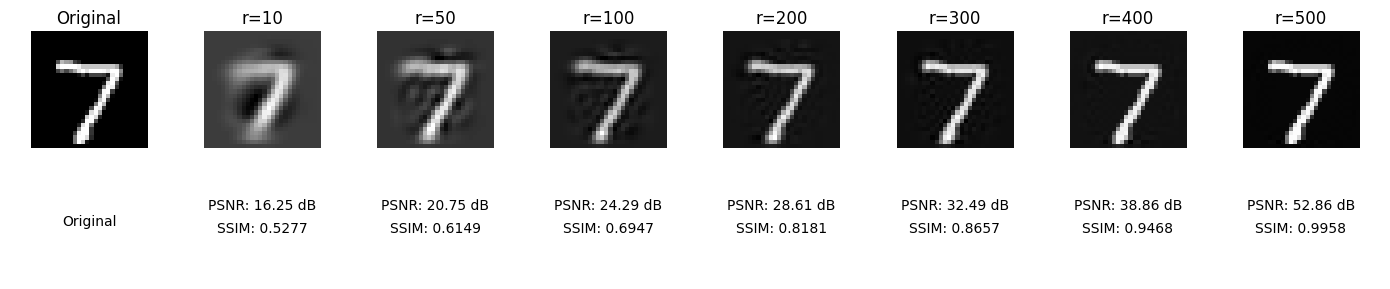

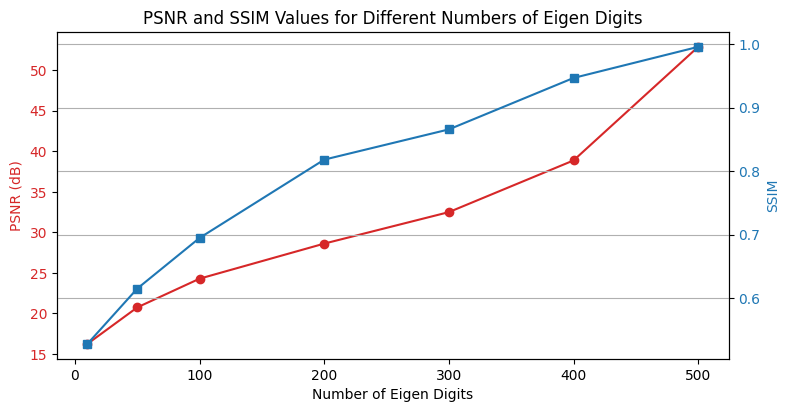

In [11]:
plot_analysis(X_test_flat[0])

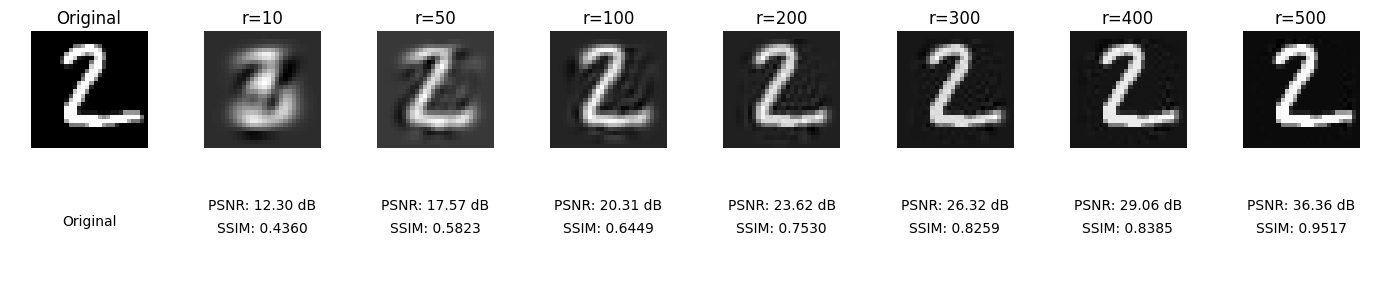

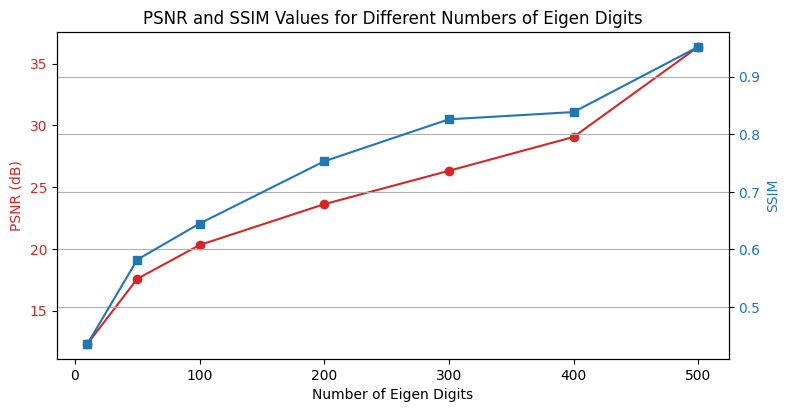

In [12]:
plot_analysis(X_test_flat[1])

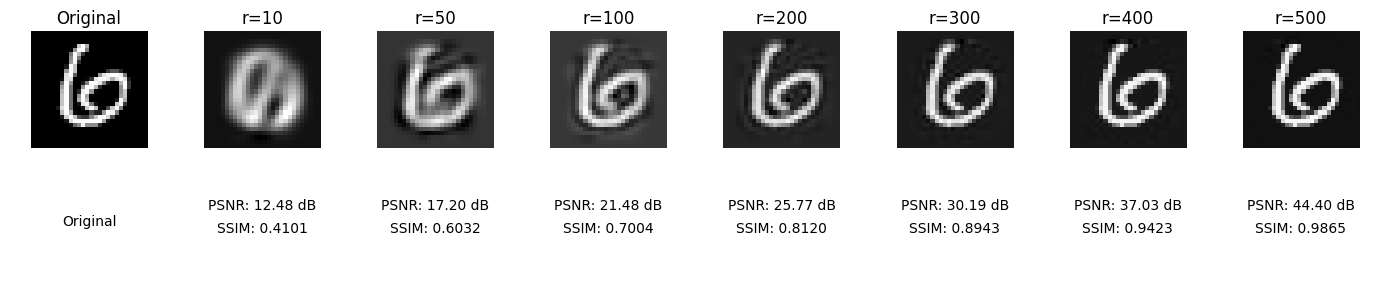

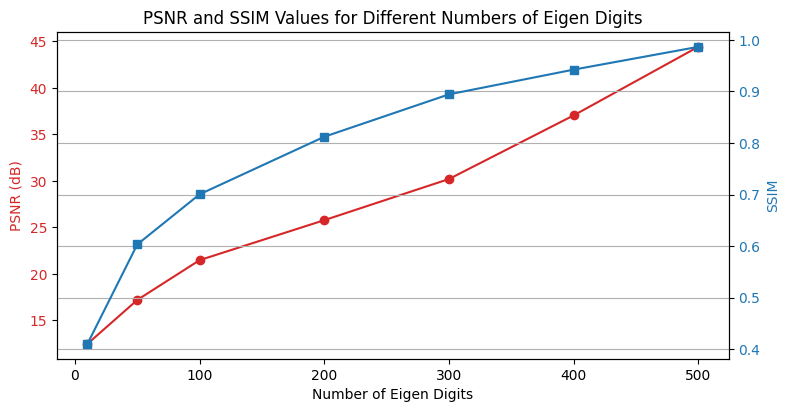

In [13]:
plot_analysis(X_test_flat[11])

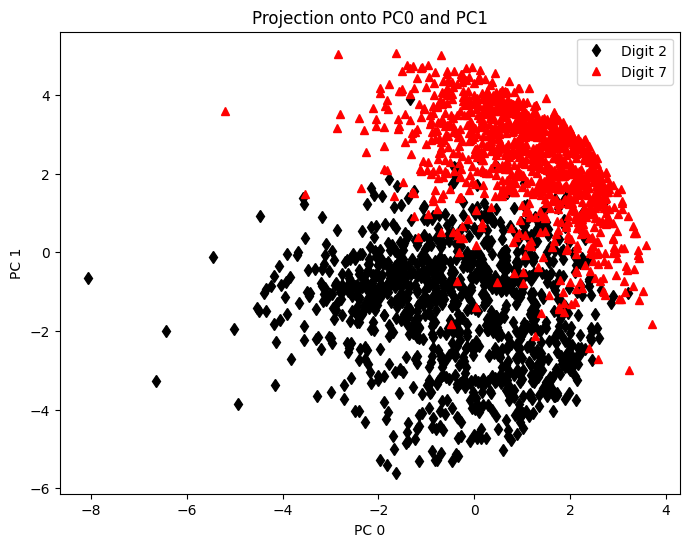

In [14]:
# Define person numbers as digits in this case
D1num = 2  # Digit number 2
D2num = 7  # Digit number 7

D1_indices = np.where(Y_test == D1num)[0]
D2_indices = np.where(Y_test == D2num)[0]

D1 = X_test_flat[D1_indices]
D2 = X_test_flat[D2_indices]

# Subtract the average digit from each image of D1 and D2
D1 = D1 - avg_digit
D2 = D2 - avg_digit

# Select the PCA modes (subtracting 1 because Python uses 0-indexing)
PCAmodes = [0, 1]  # Python uses 0-indexing so we subtract 1

# Project onto PCA modes 5 and 6
PCACoordsD1 = U[:, PCAmodes].T @ D1.T
PCACoordsD2 = U[:, PCAmodes].T @ D2.T

# Plotting the projections
plt.figure(figsize=(8, 6))
plt.plot(PCACoordsD1[0, :], PCACoordsD1[1, :], 'd', color='k', label='Digit 2')
plt.plot(PCACoordsD2[0, :], PCACoordsD2[1, :], '^', color='r', label='Digit 7')
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.legend()
plt.title('Projection onto PC0 and PC1')
plt.show()


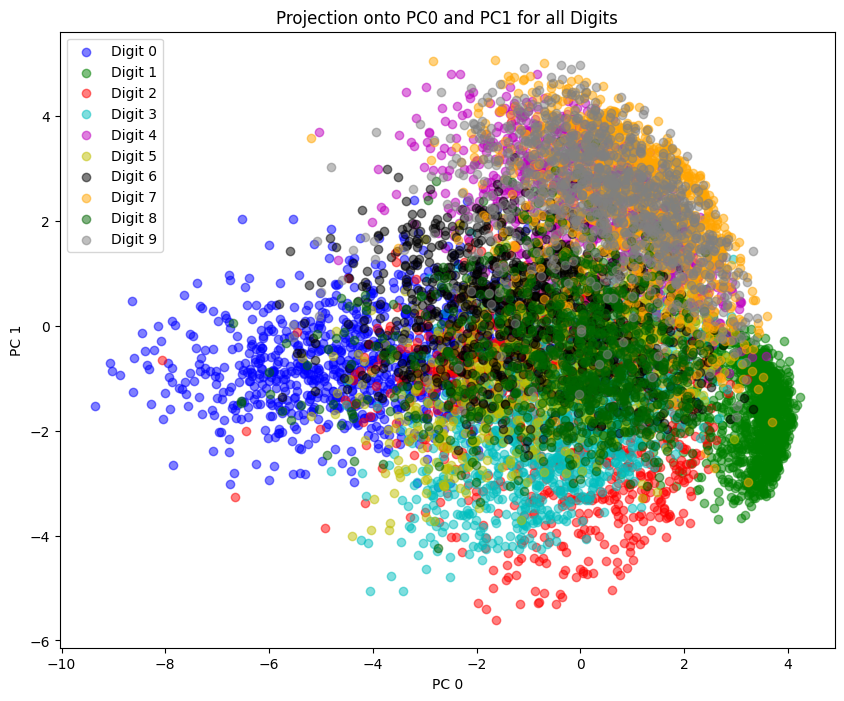

In [15]:
# Subtract the average digit from each image in the test set
X_test_centered = X_test_flat - avg_digit

# Select the PCA modes for projection
PCAmodes = [0, 1]  # Project onto the first two principal components

# Initialize a list to hold projections for each digit class
PCA_coords = []

# Calculate projections for each digit class
for digit in range(10):  # There are 10 digit classes, from 0 to 9
    indices = np.where(Y_test == digit)[0]
    digits = X_test_flat[indices]
    digits_centered = digits - avg_digit
    coords = U[:, PCAmodes].T @ digits_centered.T
    PCA_coords.append(coords)

# Plotting the projections for each digit class
plt.figure(figsize=(10, 8))

# Define colors for each digit class for better visual distinction
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'darkgreen', 'grey']

for digit, coords in enumerate(PCA_coords):
    plt.scatter(coords[0, :], coords[1, :], label=f'Digit {digit}', alpha=0.5, c=colors[digit])

plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.legend()
plt.title('Projection onto PC0 and PC1 for all Digits')
plt.show()